In [109]:
import sys
sys.path.insert(0, "../../gen")
from Config_class import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Proof of Behaviours

This notebook contains proof the vehicle model is behaving as prescribed.

## Depth

When waypoints are not determined by an operator, the underwater dive profile must be determined autonomously. 

Currently there are two independant criteria for triggering a surface event:
* When a waypoint at depth is reached
* When the AUV reaches a user defined time limit for a dive

The second condition was necessary as (depending on the behaviour) waypoints are set dynamically and hence its possible an AUV may never reach a waypoint at depth and hence continue operating at depth indefinitely accumulating uncertainty.

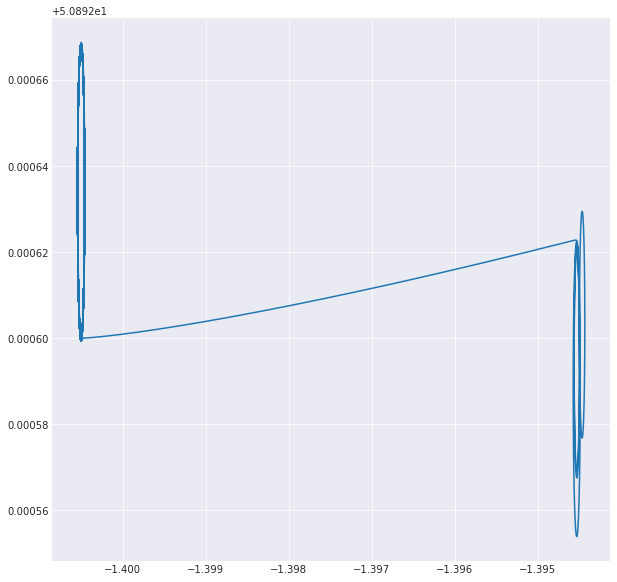

In [110]:
sim_no = 1
sns.set_style('darkgrid')
fig = plt.figure(figsize = (10, 10))
config = sim_config('vld_config_001.csv')
dfresults = pd.read_csv('vld_dive.csv')
plt.plot(dfresults.lon, dfresults.lat)
plt.show()

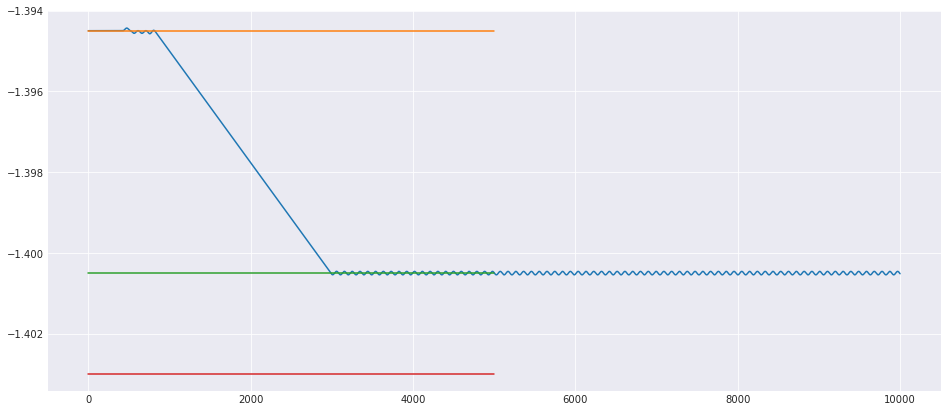

In [116]:
sim_no = 1
sns.set_style('darkgrid')
fig = plt.figure(figsize = (16, 7))
config = sim_config('vld_config_001.csv')
dfresults = pd.read_csv('vld_dive.csv')
plt.plot(dfresults.t, dfresults.lon)

waypoints = np.array([[-1.3945, 50.8926,-50],
                 [-1.4005, 50.8926, 0],
                 [-1.4030, 50.8926, -50]])
plt.plot([0,5000], [waypoints[0][0], waypoints[0][0]])
plt.plot([0,5000], [waypoints[1][0], waypoints[1][0]])
plt.plot([0,5000], [waypoints[2][0], waypoints[2][0]])

plt.show()

In [112]:
def plot_depth_proof(dfresults, config, save = False):
    xlimit = 5000
    fig = plt.figure(figsize = (14, 16))
       
    ax = plt.subplot(511)
    ax.plot(dfresults.t, dfresults.z, 'r')
    ax.plot(dfresults.t, dfresults.wp_z, 'k--')
    sat_times = dfresults[dfresults.sat_times != 0].sat_times
    ax.plot(sat_times, [0 for i in range(sat_times.shape[0])],  'ro')
#     ax.set_ylabel('Depth')
    ax.legend(['Depth','Depth Demand', 'Sat Comm Event'])
    ax.set_xlim([0, xlimit])
    ax.set_xlabel('Time')
    
    ax = plt.subplot(512)
    ax.plot(dfresults.t, dfresults.state)
    ax.set_xlim([0, xlimit])
    
    ax = plt.subplot(513)
    ax.plot(dfresults.t, dfresults.yaw)
    ax.plot(dfresults.t, dfresults.yaw_demand)
    ax.set_xlim([0, xlimit])
    
    ax = plt.subplot(514)
    ax.plot(dfresults.t, dfresults.pitch)
    ax.plot(dfresults.t, dfresults.pitch_demand)
    ax.set_xlim([0, xlimit])
    
    ax = plt.subplot(515)
    ax.plot(dfresults.t, dfresults.dist_to_wp)

    ax.set_xlim([0, xlimit])
#     ax[2].plot(dfresults['t'].tolist(), dfresults['dist_to_wp'].tolist())
#     ax[2].plot([0,5000], [5,5], 'r--')
#     ax[2].set_ylabel('Distance to WP / m')
#     ax[2].legend(['Distance to Waypoint', '5m Acceptence Radius'])

#     ax[3].plot(dfresults['t'], dfresults['state'].tolist())
#     ax[3].set_ylabel('State')
#     ax[3].legend(['Time underwater','Start Surfacing', 'Surface Immediately'])

#     ax[4].plot(dfresults.t, dfresults.time_uw)
#     ax[4].plot([0,5000], [0.5*1200,0.5*1200])
#     ax[4].plot([0,5000], [0.9*1200,0.9*1200])
#     ax[4].set_ylabel('Dive Time')

    
#     ax[1].set_xlim([0,config.run_time])
#     ax[2].set_xlim([0,config.run_time])
#     ax[3].set_xlim([0,config.run_time])
#     ax[4].set_xlim([0,config.run_time])
#     ax[4].set_ylim([0,1500])
#     f.tight_layout()

    
    plt.show()

Index(['t', 'lon', 'lat', 'z', 'wp_lon', 'wp_lat', 'wp_z', 'dist_to_wp',
       'state', 'time_uw', 'v', 'v_demand', 'v_calc', 'yaw', 'yaw_demand',
       'yaw_demand_calc', 'yaw_rate_calc', 'pitch', 'pitch_demand',
       'pitch_demand_calc', 'pitch_rate_calc', 'sat_times'],
      dtype='object')


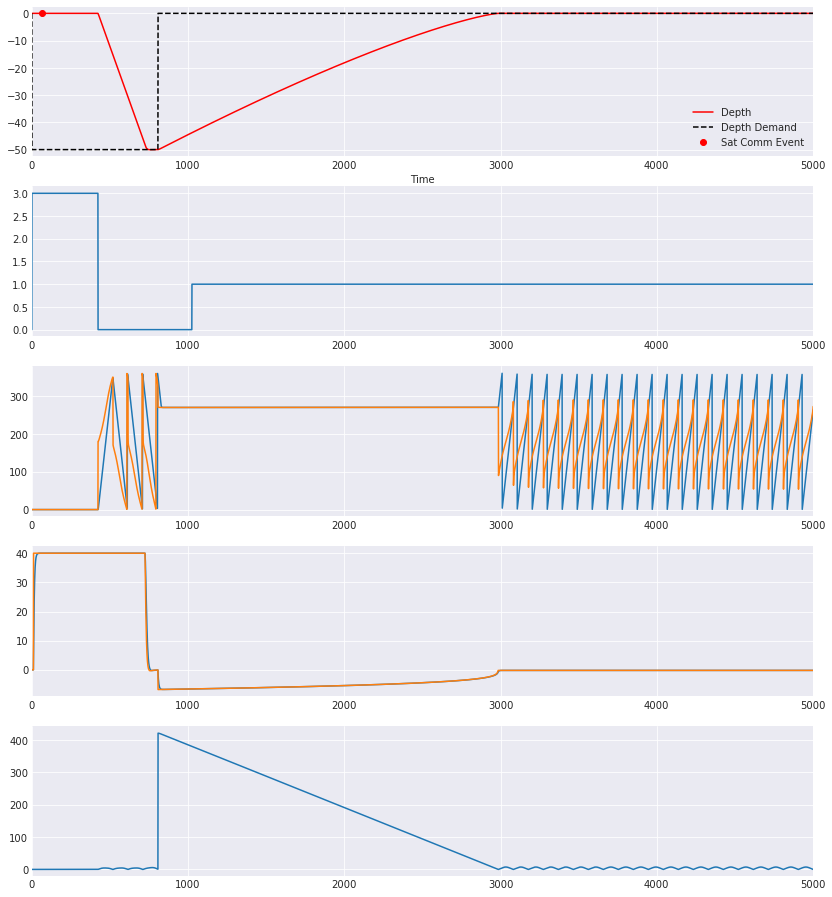

In [113]:
sim_no = 1
config = sim_config('vld_config_001.csv')
dfresults = pd.read_csv('vld_dive.csv')
print(dfresults.columns)
plot_depth_proof(dfresults, config)

Waypoints given to the AUV: [[400,0,-50], [500, 0, 0], [550, 0, -50]]

During the first dive the AUV never reaches its waypoint hence when the AUV has reached 50% of the user-defined time limit for a dive a surface is induced. The AUV is still submerged at 90% of the user-defined time limit hence sets an immediate surface directly above its current position. In the code, the waypoints are stashed and replaced with the immediate surface waypoint.

Once the AUV surfaces and communicates with the satellite, the waypoints are unstashed and the AUV loads the [400,0,-50] waypoint which was never met due to exceeeding the time limit.

The AUV then dives again to the [400,0,-50] waypoint and surfaces at the [500,0,0] waypoint. Here 50% of the time limit is reached, however the vehicle is already surfacing hence there are no changes to the waypoints. The 90% time limit for immediate surface is never reached.

The final dive shows the AUV completing a dive in one hop.

## Yaw / Heading

In this section, the process of setting yaw demand and the yaw controller are examined.

To do this the AUV was given 4 waypoints
1. [50,0,0]
2. [50,50,0]
3. [0,50,0]
4. [0,0,0]

Or a East, North, West, South box with sides of length 50.

With the datum for yaw angle being along the x axis the AUV should travel at approximate yaw angles of 0, 90, 180 then 270 degrees to reach the 4 waypoints, allowing a margin for the acceptance and turning radii of the vehicle.

In [114]:
def plot_yaw_proof(dfresults, config, save = False):
    f, ax = plt.subplots(2, figsize = (14,8))
    ax[0].plot(dfresults['t'].tolist(), dfresults['yaw'].tolist(), 'k-')
    ax[0].plot(dfresults['t'].tolist(), dfresults['yaw_demand'].tolist(), 'r-')
    ax[0].set_ylabel('Yaw / degs')
    ax[0].legend(['Yaw', 'Yaw demand'])
    ax[0].set_xlim([0,750])
    ax[1].plot(dfresults['t'].tolist(), dfresults['yaw_rate_calc'].tolist())
    ax[1].set_xlabel('Time')
    ax[1].set_ylim([-20,20])
    ax[1].set_ylabel('Yaw Rate / deg/s')  
    f.tight_layout()
    ax[1].set_xlim([0,config.run_time])
    if save == True:
        f.savefig(fn + 'figs/yaw.png')
    else:
        plt.show()
        
    fig = plt.figure(figsize = (8,8))
    plt.plot(dfresults['x'], dfresults['y'])
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()

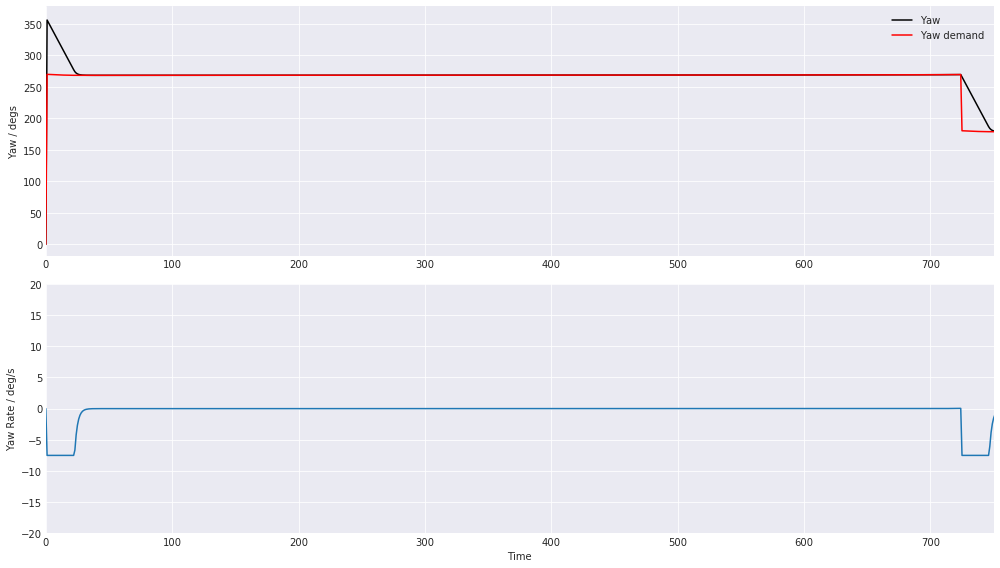

KeyError: 'x'

In [115]:
sim_no = 2
config = sim_config('vld_config_%03i.csv' % sim_no)
config.run_time = 750
dfresults = pd.read_csv('vld_yaw.csv')
plot_yaw_proof(dfresults, config)

## Speed

To prove the speed control works as intended, speed demand was set to various values. The speed is also calculated from the distance moved in each timestep for comparison against the vehicles intended velocity, proving the dead reckoner is working as intended.

The speeds set were:
1. 1.0m/s - Max speed defined in vehicle configuration
2. 1.5m/s - Vehicle shold be limited to 1.0m/s
3. 0.75m/s - Deceleration
4. 0.25m/s - Min speed defined in vehicle configuration
5. 0.0m/s - Vehicle should maintain movement at 0.25m/s

A time period of 100 timesteps was allowed for each demand.



In [ ]:
def plot_vel_proof(dfresults, config, save=False):
    f = plt.figure(figsize=(14, 4))
    plt.plot(dfresults['t'].tolist(), dfresults['v'].tolist())
    plt.plot(dfresults['t'].tolist(), dfresults['v_demand'].tolist(), 'k--', linewidth = 1.0)
    plt.plot(dfresults['t'].tolist(), dfresults['v_calc'].tolist(), 'r--')
    plt.xlabel('Time')
    plt.ylabel('Speed / m/s')
    plt.legend(['AUV log v', 'v demand', 'Calculated v'])
    plt.ylim([0,  dfresults['v_demand'].max()*1.1])
    plt.tight_layout()
    if save == True:
        plt.savefig(fn + 'figs/speeds.png')
    else:
        plt.show()

In [ ]:
sim_no = 3
config = sim_config(fn + 'vld_config_%03i.csv' % sim_no)
config.run_time = 500
dfresults = pd.read_csv(fn + 'vld_vel.csv')
plot_vel_proof(dfresults, config)